In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib notebook
import time
import datetime

#Save experiment begin date
current_time = datetime.datetime.now()
print("Current_date: "+str(current_time))
current_time = "".join(current_time.strftime("%x").split('/'))

#Import usual things required for graph nets
import numpy as np
import pandas as pd
import networkx as nx
import sonnet as snt
import tensorflow as tf
import os
import sys
from matplotlib import pyplot as plt
from matplotlib import animation
import seaborn as sns

#Import graph nets
from graph_nets import blocks
from graph_nets import utils_tf
from graph_nets import utils_np
from graph_nets.demos import models

#Change here
num_training_iterations = 10000
batch_size_tr = 256
batch_size_ge = 100
num_time_steps = 50

desc = "ntr="+str(num_training_iterations)
desc = desc +"_btr="+str(batch_size_tr)
desc = desc +"_bge="+str(batch_size_ge)
desc = desc +"_date="+str(current_time)
desc = desc +"_stepError_"

#Set seed
SEED = 1
desc = desc +"seed="+str(SEED)

#Path to the scripts shared troughout phases
parent_path=os.path.abspath('..')
path_common =  '/'.join(parent_path.split('/')[:-1])
path_common = os.path.join(path_common,'Common','Scripts')
#Check if path exists
if(not os.path.exists(path_common)):
    print('The path: '+ os.path.exists(path_common)+' is not found!')
#Add shared scripts to our current paths for importing
sys.path.insert(0, path_common)

base = os.path.join(parent_path,'Moving_Rigidbody','damping','no_gravity')
if(not os.path.exists(base)):
    os.makedirs(base)
#Path to saved models and trajectories
path_saves = os.path.join(base,desc,'Saves')
if(not os.path.exists(path_saves)):
    os.makedirs(path_saves)
#Path to plots
path_plots = os.path.join(base,desc,'Plots')
if(not os.path.exists(path_plots)):
    os.makedirs(path_plots)
#Path to animations
path_animations = os.path.join(base,desc,'Animations')
if(not os.path.exists(path_animations)):
    os.makedirs(path_animations)



np.random.seed(SEED)
tf.set_random_seed(SEED)

Current_date: 2020-03-01 20:13:11.302964

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Import functions

In [2]:
#Import functions for simulating
from Simulation_functions_moving_contact import SpringMassSimulator, generate_trajectory, roll_out_physics
#Import functions for creating graph
from Graph_creator_functions import rigid_rectangle_graph_extended
#Import visualisation functions

## Define loss functions

In [3]:
def create_loss_ops(target_op, output_ops):
    """Create supervised loss operations from targets and outputs.

    Args:
        target_op: The target velocity tf.Tensor.
        output_ops: The list of output graphs from the model.

    Returns:
        A list of loss values (tf.Tensor), one per output op.""" 
    loss_ops = [
            tf.reduce_mean(
            tf.reduce_sum((tf.cast(output_op.nodes,tf.float64) - tf.cast(target_op[..., 2:4],tf.float64))**2, axis=-1))
            for output_op in output_ops
    ]
    return loss_ops


def make_all_runnable_in_session(*args):
    """Apply make_runnable_in_session to an iterable of graphs."""
    return [utils_tf.make_runnable_in_session(a) for a in args]

# Define the Model

In [4]:
tf.reset_default_graph()
# Create the model.
model = models.EncodeProcessDecode(node_output_size=2)

# Training the Network: Chain
## Generate:
- Model
- Training trajectory 5 to 9 masses
- Generalization trajectories: 4 mass, 7 mass and 11 mass

In [5]:
#@title Set up model training and evaluation  { form-width: "30%" }

# The model we explore includes three components:
# - An "Encoder" graph net, which independently encodes the edge, node, and
#   global attributes (does not compute relations etc.).
# - A "Core" graph net, which performs N rounds of processing (message-passing)
#   steps. The input to the Core is the concatenation of the Encoder's output
#   and the previous output of the Core (labeled "Hidden(t)" below, where "t" is
#   the processing step).
# - A "Decoder" graph net, which independently decodes the edge, node, and
#   global attributes (does not compute relations etc.), on each
#   message-passing step.
#
#                     Hidden(t)   Hidden(t+1)
#                        |            ^
#           *---------*  |  *------*  |  *---------*
#           |         |  |  |      |  |  |         |
# Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
#           |         |---->|      |     |         |
#           *---------*     *------*     *---------*
#
# The model is trained by supervised learning. Input mass-spring systems are
# procedurally generated, where the nodes represent the positions, velocities,
# and indicators of whether the mass is fixed in space or free to move, the
# edges represent the spring constant and spring rest length, and the global
# attribute represents the variable coefficient of gravitational acceleration.
# The outputs/targets have the same structure, with the nodes representing the
# masses' next-step states.
#
# The training loss is computed on the output of each processing step. The
# reason for this is to encourage the model to try to solve the problem in as
# few steps as possible. It also helps make the output of intermediate steps
# more interpretable.
#
# There's no need for a separate evaluate dataset because the inputs are
# never repeated, so the training loss is the measure of performance on graphs
# from the input distribution.
#
# We also evaluate how well the models generalize to systems which are one mass
# larger, and smaller, than those from the training distribution. The loss is
# computed as the mean over a 50-step rollout, where each step's input is the
# the previous step's output.
#
# Variables with the suffix _tr are training parameters, and variables with the
# suffix _ge are test/generalization parameters.
#
# After around 10000-20000 training iterations the model reaches good
# performance on mass-spring systems with 5-8 masses.


rand = np.random.RandomState(SEED)

# Model parameters.
num_processing_steps_tr = 1
num_processing_steps_ge = 1

step_size = 0.1
lena_min_max_tr = (1, 2.5)
lenb_min_max_tr = (1, 2)
pos_noise_min_max_tr = (-0.5,0.5)
vel_noise_min_max_tr = (-0.5,0.5)
spring_constant_min_max_tr = (40,60)
damping_ratio_min_max_tr = (0.3,0.6)

# Data.
# Base graphs for training.
lena_tr = rand.uniform(*lena_min_max_tr, size=batch_size_tr)
lenb_tr = rand.uniform(*lenb_min_max_tr, size=batch_size_tr)

pos_noise_tr = rand.uniform(*pos_noise_min_max_tr, size=batch_size_tr)
vel_noise_tr = rand.uniform(*vel_noise_min_max_tr, size=batch_size_tr)

posa_tr = np.array([ 3, 3,-3,-3]*int(batch_size_tr/4)) + np.array(pos_noise_tr)
posb_tr = np.array([ 3,-3, 3,-3]*int(batch_size_tr/4)) + np.array(pos_noise_tr)
vela_tr = np.array([-1,-1, 1, 1]*int(batch_size_tr/4)) + np.array(vel_noise_tr)
velb_tr = np.array([-1, 1,-1, 1]*int(batch_size_tr/4)) + np.array(vel_noise_tr)

spring_constants_tr = rand.randint(*spring_constant_min_max_tr, size=batch_size_tr)
damping_ratios_tr = rand.uniform(*damping_ratio_min_max_tr, size=batch_size_tr)

dict_rands = {"lena":lena_tr,
              "lenb":lenb_tr,
              "spring_constants":spring_constants_tr,
              "damping_ratios":damping_ratios_tr}


if os.path.exists(os.path.join(path_saves, "training_examples")):
    print("The file: "+ "training_examples" + "already exists. Delete it before saving a new trajectory!")
else:
    if not os.path.exists(os.path.join(path_saves)):
        os.makedirs(os.path.join(path_saves)) 
    np.save(os.path.join(path_saves, "training_examples"), dict_rands)
    


static_graph_tr = [rigid_rectangle_graph_extended(a,b,c,True,d,p_a,p_b,v_a,v_b,2) for a,b,c,d,p_a,p_b,v_a,v_b in zip(lena_tr, lenb_tr,
                                                                                                                    spring_constants_tr,
                                                                                                                     damping_ratios_tr,
                                                                                                                     posa_tr,posb_tr,
                                                                                                                     vela_tr,velb_tr)]
contact_nodes_tr = [static_graph_tr[i]['receivers'][-2:] for i in range(batch_size_tr)]

base_graph_tr = utils_tf.data_dicts_to_graphs_tuple(static_graph_tr)









# Base graphs for testing.
lena_min_max_te = (1, 2.5)
lenb_min_max_te = (1, 2)
pos_noise_min_max_te = (-0.5,0.5)
vel_noise_min_max_te = (-0.5,0.5)
spring_constant_min_max_te = (40,60)
damping_ratio_min_max_te = (0.3,0.6)

lena_te = rand.uniform(*lena_min_max_te, size=batch_size_ge)
lenb_te = rand.uniform(*lenb_min_max_te, size=batch_size_ge)

pos_noise_te = rand.uniform(*pos_noise_min_max_te, size=batch_size_ge)
vel_noise_te = rand.uniform(*vel_noise_min_max_te, size=batch_size_ge)

posa_te = np.array([ 3, 3,-3,-3]*int(batch_size_ge/4)) + np.array(pos_noise_te)
posb_te = np.array([ 3,-3, 3,-3]*int(batch_size_ge/4)) + np.array(pos_noise_te)
vela_te = np.array([-1,-1, 1, 1]*int(batch_size_ge/4)) + np.array(vel_noise_te)
velb_te = np.array([-1, 1,-1, 1]*int(batch_size_ge/4)) + np.array(vel_noise_te)

spring_constants_te = rand.randint(*spring_constant_min_max_te, size=batch_size_ge)
damping_ratios_te = rand.uniform(*damping_ratio_min_max_te, size=batch_size_ge)

static_graph_te = [rigid_rectangle_graph_extended(a,b,c,True,d,p_a,p_b,v_a,v_b,2) for a,b,c,d,p_a,p_b,v_a,v_b in zip(lena_te,lenb_te,
                                                                                                                     spring_constants_te,
                                                                                                                   damping_ratios_te,
                                                                                                                   posa_te,posb_te,
                                                                                                                   vela_te,velb_te)]
contact_nodes_te = [static_graph_te[i]['receivers'][-2:] for i in range(batch_size_ge)]
base_graph_te = utils_tf.data_dicts_to_graphs_tuple(static_graph_te)

# Base graphs for extrapolation.
lena_min_max_ge = (0.5, 4)
lenb_min_max_ge = (0.5, 3)
pos_noise_min_max_ge = (-0.5,0.5)
vel_noise_min_max_ge = (-0.5,0.5)
spring_constant_min_max_ge = (25,75)
damping_ratio_min_max_ge = (0.2,0.8)

lena_ge = rand.uniform(*lena_min_max_ge, size=batch_size_ge)
lenb_ge = rand.uniform(*lenb_min_max_ge, size=batch_size_ge)

pos_noise_ge = rand.uniform(*pos_noise_min_max_ge, size=batch_size_ge)
vel_noise_ge = rand.uniform(*vel_noise_min_max_ge, size=batch_size_ge)

posa_ge = np.array([ 3, 3,-3,-3]*int(batch_size_ge/4)) + np.array(pos_noise_ge)
posb_ge = np.array([ 3,-3, 3,-3]*int(batch_size_ge/4)) + np.array(pos_noise_ge)
vela_ge = np.array([-1,-1, 1, 1]*int(batch_size_ge/4)) + np.array(vel_noise_ge)
velb_ge = np.array([-1, 1,-1, 1]*int(batch_size_ge/4)) + np.array(vel_noise_ge)


spring_constants_ge = rand.randint(*spring_constant_min_max_ge, size=batch_size_ge)
damping_ratios_ge = rand.uniform(*damping_ratio_min_max_ge, size=batch_size_ge)


static_graph_ge = [rigid_rectangle_graph_extended(a,b,c,True,d,p_a,p_b,v_a,v_b,2) for a,b,c,d,p_a,p_b,v_a,v_b in zip(lena_ge,lenb_ge,
                                                                                                                    spring_constants_ge,
                                                                                                                   damping_ratios_ge,
                                                                                                                   posa_ge,posb_ge,
                                                                                                                   vela_ge,velb_ge)]
contact_nodes_ge = [static_graph_ge[i]['receivers'][-2:] for i in range(batch_size_ge)]
base_graph_ge = utils_tf.data_dicts_to_graphs_tuple(static_graph_ge)









# True physics simulator for data generation.
simulator = SpringMassSimulator(step_size=step_size)
# Training.
# Generate a training trajectory by adding noise to initial
# position, spring constants and gravity
initial_conditions_tr, true_trajectory_tr = generate_trajectory(
    simulator,
    base_graph_tr,
    num_time_steps,
    step_size,
    node_noise_level=0.04,
    edge_noise_level=5.0,
    global_noise_level=1.0,
    do_set_rest=True,
    do_apply_gravity=False)
# Random start step.
t = tf.random_uniform([], minval=0, maxval=num_time_steps - 1, dtype=tf.int32)
input_graph_tr = initial_conditions_tr.replace(nodes=true_trajectory_tr[t])
target_nodes_tr = true_trajectory_tr[t + 1]

output_ops_tr = model(input_graph_tr, num_processing_steps_tr)






# Test data:
initial_conditions_te, true_trajectory_te = generate_trajectory(
    simulator,
    base_graph_te,
    num_time_steps,
    step_size,
    node_noise_level=0.04,
    edge_noise_level=5.0,
    global_noise_level=1.0,
    do_set_rest=True,
    do_apply_gravity=False)

input_graph_te = initial_conditions_te.replace(nodes=true_trajectory_te[t])
target_nodes_te = true_trajectory_te[t + 1]

output_ops_te = model(input_graph_te, num_processing_steps_ge)

_, true_nodes_rollout_te = roll_out_physics(
    simulator, initial_conditions_te, num_time_steps, step_size)
_, predicted_nodes_rollout_te = roll_out_physics(
    lambda x: model(x, num_processing_steps_ge), initial_conditions_te,
    num_time_steps, step_size)




# Extrapolation data:
initial_conditions_ge, true_trajectory_ge = generate_trajectory(
    simulator,
    base_graph_ge,
    num_time_steps,
    step_size,
    node_noise_level=0.04,
    edge_noise_level=5.0,
    global_noise_level=1.0,
    do_set_rest=True,
    do_apply_gravity=False)

input_graph_ge = initial_conditions_ge.replace(nodes=true_trajectory_ge[t])
target_nodes_ge = true_trajectory_ge[t + 1]

output_ops_ge = model(input_graph_ge, num_processing_steps_ge)

_, true_nodes_rollout_ge = roll_out_physics(
    simulator, initial_conditions_ge, num_time_steps, step_size)
_, predicted_nodes_rollout_ge = roll_out_physics(
    lambda x: model(x, num_processing_steps_ge), initial_conditions_ge,
    num_time_steps, step_size)




# Training loss.
loss_ops_tr = create_loss_ops(target_nodes_tr, output_ops_tr)
# Training loss across processing steps.
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr

# Test loss
loss_ops_te = create_loss_ops(target_nodes_te,output_ops_te)
loss_op_step_te = sum(loss_ops_te) / num_processing_steps_ge
loss_op_te = tf.reduce_mean(
    tf.reduce_sum(
        (predicted_nodes_rollout_te[..., 2:4] -
         true_nodes_rollout_te[..., 2:4])**2,
        axis=-1))

print(predicted_nodes_rollout_te.shape)
print(true_nodes_rollout_te.shape)
print(loss_op_te.shape)

# Extrapolation loss
loss_ops_ge = create_loss_ops(target_nodes_ge,output_ops_ge)
loss_op_step_ge = sum(loss_ops_ge) / num_processing_steps_ge
loss_op_ge = tf.reduce_mean(
    tf.reduce_sum(
        (predicted_nodes_rollout_ge[..., 2:4] -
         true_nodes_rollout_ge[..., 2:4])**2,
        axis=-1))



# Optimizer.
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

input_graph_tr = make_all_runnable_in_session(input_graph_tr)
initial_conditions_te = make_all_runnable_in_session(initial_conditions_te)
initial_conditions_ge = make_all_runnable_in_session(initial_conditions_ge)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

(?, 500, 5)
(?, 500, 5)
()


In [6]:
print(spring_constants_ge)
print(damping_ratios_ge)

[72 63 47 71 62 61 35 64 38 44 70 59 60 32 32 26 63 28 71 31 28 33 61 45
 73 67 42 39 40 60 73 68 68 46 68 28 71 71 27 25 42 43 70 26 73 52 57 44
 45 57 68 45 36 59 51 61 71 62 49 65 31 69 55 58 26 46 50 71 25 71 38 65
 28 40 31 28 72 67 26 42 72 72 41 29 46 54 69 57 27 59 49 47 38 58 63 35
 46 41 39 32]
[0.29645849 0.62974298 0.78237122 0.75773023 0.7406402  0.27664599
 0.28755735 0.24335885 0.52552414 0.7294917  0.51907514 0.66902917
 0.31307227 0.71786676 0.31245486 0.23285848 0.45289461 0.53306266
 0.78244521 0.2550523  0.36435086 0.26306424 0.43426378 0.37340665
 0.50798021 0.40895401 0.75693681 0.67396868 0.71660682 0.27770057
 0.5450421  0.32886952 0.72094314 0.20901165 0.26344653 0.42563425
 0.44125634 0.36633205 0.2576378  0.27123824 0.39076685 0.7704757
 0.32444394 0.64836819 0.3549132  0.22234415 0.20963133 0.29162356
 0.47725052 0.65354066 0.63728896 0.41143367 0.48748357 0.68844425
 0.70304174 0.39195002 0.20255901 0.22815851 0.64268443 0.36357937
 0.48889149 0.31521876 0.

### Reset Tensorflow session, but keep the same computational graph.

In [7]:
#@title Reset session  { form-width: "30%" }


saver = tf.train.Saver()
# This cell resets the 
try:
    sess.close()
except NameError:
    pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())

var = [v for v in tf.trainable_variables() if v.name == 'MLPGraphNetwork/graph_network/edge_block/mlp/linear_0/w:0']
pre_train_np = sess.run(var)
print(pre_train_np)


last_iteration = 0
logged_iterations = []
logged_timesteps = []
losses_tr = []
losses_te = []
losses_step_te = []
losses_ge = []
losses_step_ge = []

[array([[-0.05547576, -0.1485468 , -0.08163285, ...,  0.15303856,
         0.04122149,  0.05914256],
       [ 0.11060496,  0.08666073,  0.08816289, ...,  0.1216699 ,
        -0.01828691, -0.11734179],
       [ 0.02451585, -0.17280431,  0.13709697, ..., -0.11309081,
         0.03142837,  0.06112709],
       ...,
       [ 0.04055208, -0.0151289 , -0.05680978, ...,  0.08104839,
         0.06392947,  0.00932366],
       [-0.02727162,  0.03841643, -0.16847466, ..., -0.02819572,
         0.11615083,  0.10055492],
       [ 0.03729214, -0.01103949, -0.15424015, ...,  0.00122257,
         0.04348828, -0.05123207]], dtype=float32)]


### Train Network

In [8]:
#@title Run training  { form-width: "30%" }

# You can interrupt this cell's training loop at any time, and visualize the
# intermediate results by running the next cell (below). You can then resume
# training by simply executing this cell again.

# How much time between logging and printing the current results.
log_every_iteration = 250

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training 1-step loss), "
      "Lte (test 1-step loss for test rigidbodies), "
      "Lge (generalization 1-step loss for extrapolation rigidbodies)")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
    last_iteration = iteration
    train_values = sess.run({
        "step": step_op,
        "loss": loss_op_tr,
        "input_graph": input_graph_tr,
        "target_nodes": target_nodes_tr,
        "outputs": output_ops_tr,
        "time_step":t
    })
    if last_iteration % log_every_iteration == 0:
        
        the_time = time.time()
        elapsed_since_last_log = the_time - last_log_time
        last_log_time = the_time
        test_values = sess.run({
            "step_loss_te":loss_op_step_te,
            "loss_te": loss_op_te,
            "true_rollout_te": true_nodes_rollout_te,
            "predicted_rollout_te": predicted_nodes_rollout_te,
            "step_loss_ge":loss_op_step_ge,
            "loss_ge": loss_op_ge,
            "true_rollout_ge": true_nodes_rollout_ge,
            "predicted_rollout_ge": predicted_nodes_rollout_ge
        })
        elapsed = time.time() - start_time
        losses_tr.append(train_values["loss"])
        losses_te.append(test_values["loss_te"])
        losses_step_te.append(test_values["step_loss_te"])
        losses_ge.append(test_values["loss_ge"])
        losses_step_ge.append(test_values["step_loss_ge"])
        logged_iterations.append(iteration)
        logged_timesteps.append(train_values["time_step"])
        print("# {:05d}, T {:.1f}, Ltr {:.4f}, Lte {:.4f}, Lge {:.4f}, TimeStep {:03d}".format(
            iteration, elapsed, train_values["loss"], test_values["loss_te"],
            test_values["loss_ge"],train_values["time_step"]))

# (iteration number), T (elapsed seconds), Ltr (training 1-step loss), Lte (test 1-step loss for test rigidbodies), Lge (generalization 1-step loss for extrapolation rigidbodies)
# 00000, T 1.6, Ltr 4.5093, Lte 3.6878, Lge 3.6750, TimeStep 038
# 00250, T 6.6, Ltr 0.1579, Lte 2.9366, Lge 2.8413, TimeStep 012
# 00500, T 11.6, Ltr 0.0672, Lte 2.3080, Lge 2.2669, TimeStep 022
# 00750, T 16.7, Ltr 0.0534, Lte 2.7240, Lge 2.5049, TimeStep 028
# 01000, T 21.7, Ltr 0.0658, Lte 1.8587, Lge 2.0684, TimeStep 013
# 01250, T 26.8, Ltr 0.2462, Lte 1.5240, Lge 1.7340, TimeStep 004
# 01500, T 31.7, Ltr 0.2741, Lte 1.8733, Lge 1.8283, TimeStep 003
# 01750, T 36.8, Ltr 0.3064, Lte 1.6999, Lge 1.6861, TimeStep 002
# 02000, T 41.8, Ltr 0.0740, Lte 1.6443, Lge 1.6162, TimeStep 011
# 02250, T 46.8, Ltr 0.0232, Lte 1.8560, Lge 1.8381, TimeStep 047
# 02500, T 51.8, Ltr 0.0200, Lte 1.6182, Lge 1.6148, TimeStep 032
# 02750, T 56.8, Ltr 0.0231, Lte 1.9600, Lge 2.0961, TimeStep 022
# 03000, T 61.9, Ltr 0.0256, Lt

In [9]:
var = [v for v in tf.trainable_variables() if v.name == 'MLPGraphNetwork/graph_network/edge_block/mlp/linear_0/w:0']
post_train_np = sess.run(var)
print(np.array(post_train_np)-np.array(pre_train_np))

[[[-0.02984644  0.07130008  0.00861097 ... -0.01449524  0.01650281
   -0.02238062]
  [ 0.00645062 -0.05111261  0.01393446 ... -0.02535065 -0.00296773
    0.04926085]
  [-0.0022607   0.05674659 -0.01821572 ...  0.04703744  0.02170596
   -0.02323415]
  ...
  [-0.03837301  0.0742066   0.0731019  ...  0.00654365 -0.00464184
   -0.03923378]
  [-0.04870512  0.01819375  0.03733538 ...  0.01768295 -0.07979763
   -0.05412993]
  [ 0.03865066  0.02167981  0.0384554  ... -0.01616569 -0.06020781
   -0.03877473]]]


## Save Model

In [10]:
if os.path.exists(os.path.join(path_saves, "model.ckpt")):
    print("The file: "+ "model.ckpt" + "already exists. Delete it before saving a new trajectory!")
else:
    save_path = saver.save(sess, os.path.join(path_saves)+"/model.ckpt")
    print("Model saved in path: %s" % save_path)
        
        



Model saved in path: /home/bence/git_workspace/Dyadic_Collaboration/Graph_Networks/Phases/Phase1/Moving_Rigidbody/damping/no_gravity/ntr=10000_btr=256_bge=100_date=030120_stepError_seed=1/Saves/model.ckpt


## Load Model (Optional)

In [14]:
saver.restore(sess,os.path.join(path_saves)+"/model.ckpt")

var = [v for v in tf.trainable_variables() if v.name == 'MLPGraphNetwork/graph_network/edge_block/mlp/linear_0/w:0']
post_restore_np = sess.run(var)
print(np.array(post_restore_np))

INFO:tensorflow:Restoring parameters from /home/bence/git_workspace/Dyadic_Collaboration/Graph_Networks/Phases/Phase1/Moving_Rigidbody/damping/no_gravity_fixed_box/ntr=100000_btr=256_bge=100_date=022720_stepError_seed=2/Saves/model.ckpt
[[[-0.05963716 -0.11897703 -0.0325591  ...  0.05834819  0.09264409
   -0.01879958]
  [-0.0295059  -0.05538755  0.09914996 ...  0.04518692  0.00100347
    0.00506113]
  [-0.11767392  0.07010367  0.07935341 ... -0.02501107  0.02259522
    0.05442892]
  ...
  [-0.01352745  0.01424113  0.03041505 ...  0.01246728 -0.01679761
   -0.01667246]
  [ 0.07930374  0.16084282  0.1677343  ... -0.04151856  0.03499677
    0.03428251]
  [-0.0041389  -0.03237791  0.02557529 ... -0.03608939  0.006133
   -0.05274903]]]


## Save Trajectories

In [11]:
#Describe the experiment


def get_node_trajectories(rollout_array, batch_size):
    return np.split(rollout_array[..., :4], batch_size, axis=1)

#Store the data
true_rollouts_te = get_node_trajectories(test_values["true_rollout_te"],batch_size_ge)
true_trajectory_te_np = np.array(true_rollouts_te)

predicted_rollouts_te = get_node_trajectories(test_values["predicted_rollout_te"],batch_size_ge)
predicted_trajectory_te_np=np.array(predicted_rollouts_te)

true_rollouts_ge = get_node_trajectories(test_values["true_rollout_ge"],batch_size_ge)
true_trajectory_ge_np = np.array(true_rollouts_ge)

predicted_rollouts_ge = get_node_trajectories(test_values["predicted_rollout_ge"],batch_size_ge)
predicted_trajectory_ge_np=np.array(predicted_rollouts_ge)


l_names = ["true_trajectory_te.npy",
           "predicted_trajectory_te.npy",
           "true_trajectory_ge.npy",
           "predicted_trajectory_ge.npy"]

l_data = [true_trajectory_te_np,
          predicted_trajectory_te_np,
          true_trajectory_ge_np,
          predicted_trajectory_ge_np]


for fname, fdata in zip(l_names,l_data):
    if os.path.exists(os.path.join(path_saves, fname)):
        print("The file: "+ fname + "already exists. Delete it before saving a new trajectory!")
    else:
        if not os.path.exists(os.path.join(path_saves)):
            os.mkdir(os.path.join(path_saves)) 
        np.save(os.path.join(path_saves, fname), fdata)

In [12]:
# Choose a simulated system
index_of_simulated_system = -1

spring_const = spring_constants_ge[index_of_simulated_system]
damping_ratio = damping_ratios_ge[index_of_simulated_system]

contact_nodes_te = contact_nodes_te[index_of_simulated_system]
true_trajectory_te_np = true_trajectory_te_np[index_of_simulated_system]
predicted_trajectory_te_np = predicted_trajectory_te_np[index_of_simulated_system]
contact_nodes_ge = contact_nodes_ge[index_of_simulated_system]
true_trajectory_ge_np = true_trajectory_ge_np[index_of_simulated_system]
predicted_trajectory_ge_np = predicted_trajectory_ge_np[index_of_simulated_system]

## Plot and Save Convergence plot

<IPython.core.display.Javascript object>


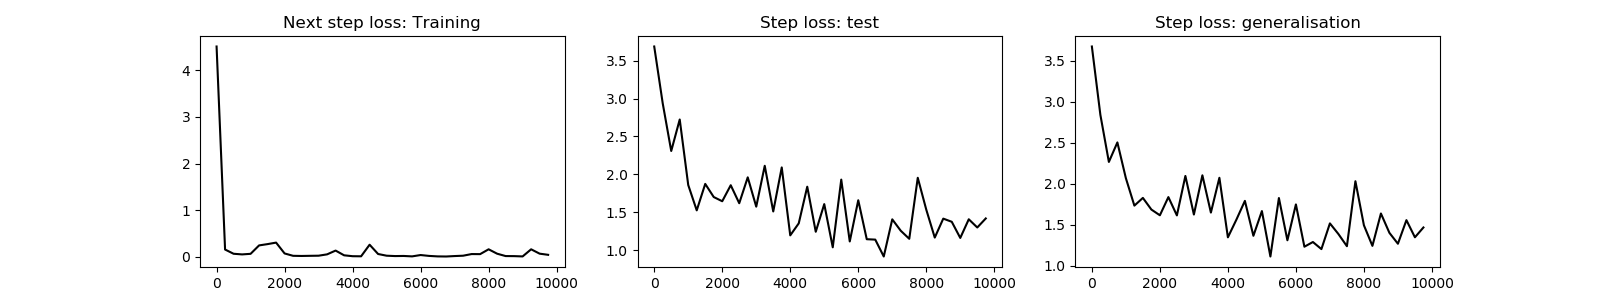

In [13]:
fig = plt.figure(1, figsize=(16, 3))
fig.clf()
x = np.array(logged_iterations)



if os.path.exists(os.path.join(path_saves, "logged_iterations")):
    print("The file: "+ "logged_iterations" + "already exists. Delete it before saving a new trajectory!")
else:
    if not os.path.exists(os.path.join(path_saves)):
        os.makedirs(os.path.join(path_saves)) 
    np.save(os.path.join(path_saves, "logged_iterations"), x)
    
if os.path.exists(os.path.join(path_saves, "logged_time_steps")):
    print("The file: "+ "logged_time_steps" + "already exists. Delete it before saving a new trajectory!")
else:
    if not os.path.exists(os.path.join(path_saves)):
        os.makedirs(os.path.join(path_saves)) 
    np.save(os.path.join(path_saves, "logged_time_steps"), logged_timesteps)
        
# Next-step Loss.
y = losses_tr
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y, "k")
ax.set_title("Next step loss: Training")

if os.path.exists(os.path.join(path_saves, "losses_tr")):
    print("The file: "+ "losses_tr" + "already exists. Delete it before saving a new trajectory!")
else:
    if not os.path.exists(os.path.join(path_saves)):
        os.makedirs(os.path.join(path_saves)) 
    np.save(os.path.join(path_saves, "losses_tr"), losses_tr)


        
# Rollout 4 loss.
y = losses_te
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y, "k")
ax.set_title("Step loss: test")

if os.path.exists(os.path.join(path_saves, "losses_step_te")):
    print("The file: "+ "losses_step_te" + "already exists. Delete it before saving a new trajectory!")
else:
    if not os.path.exists(os.path.join(path_saves)):
        os.makedirs(os.path.join(path_saves)) 
    np.save(os.path.join(path_saves, "losses_step_te"), losses_step_te)

if os.path.exists(os.path.join(path_saves, "losses_te")):
    print("The file: "+ "losses_te" + "already exists. Delete it before saving a new trajectory!")
else:
    if not os.path.exists(os.path.join(path_saves)):
        os.makedirs(os.path.join(path_saves)) 
    np.save(os.path.join(path_saves, "losses_te"), losses_te)


# Rollout 7 loss.
y = losses_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y, "k")
ax.set_title("Step loss: generalisation")

if os.path.exists(os.path.join(path_saves, "losses_step_ge")):
    print("The file: "+ "losses_step_ge" + "already exists. Delete it before saving a new trajectory!")
else:
    if not os.path.exists(os.path.join(path_saves)):
        os.makedirs(os.path.join(path_saves)) 
    np.save(os.path.join(path_saves, "losses_step_ge"), losses_step_ge)

if os.path.exists(os.path.join(path_saves, "losses_ge")):
    print("The file: "+ "losses_ge" + "already exists. Delete it before saving a new trajectory!")
else:
    if not os.path.exists(os.path.join(path_saves)):
        os.makedirs(os.path.join(path_saves)) 
    np.save(os.path.join(path_saves, "losses_ge"), losses_ge)


#Save figure
if os.path.exists(os.path.join(path_plots,"ConvergencePlot.png")):
    print("The file: "+ "ConvergencePlot.png" + "already exists. Delete it before saving a new plot!")
else:
    if not os.path.exists(os.path.join(path_plots)):
        os.mkdir(os.path.join(path_plots))
                  
    fig.savefig(os.path.join(path_plots,"ConvergencePlot.png"))

## Plot and Save Trajectories Error plot

### Plot generated groundtruth for test system

<IPython.core.display.Javascript object>


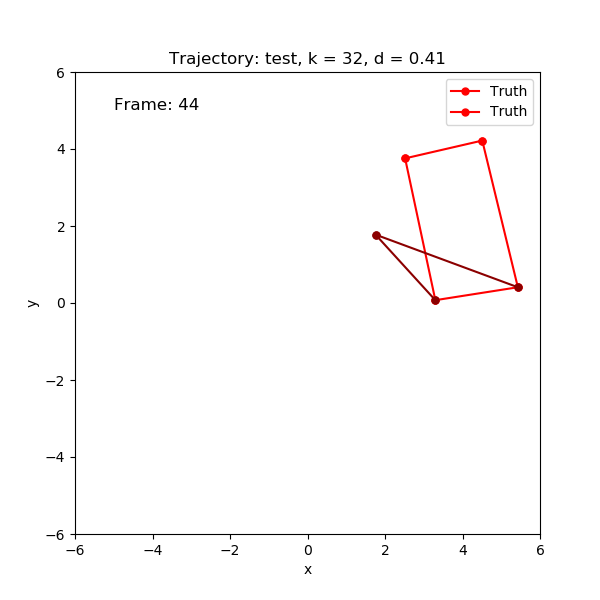

In [14]:

# Visualize trajectories
plt.close('all')
fig_animate3 = plt.figure(1, figsize=(6, 6))
ax3 = fig_animate3.add_subplot(1, 1, 1)

# Visualize trajectories for number_of_masses = 4
edges = []
contact_edges = []
time_text = ax3.text(-5, 5, "Frame: "+str(0),fontsize=12)
num_nodes = true_trajectory_te_np.shape[1]

def init():
    for i in range(num_nodes-1):
        if(i==0):
            edges.append(ax3.plot([],[], linestyle='-', marker='o', markersize=5, color="red",label="Truth"))
        else:
            edges.append(ax3.plot([],[], linestyle='-', marker='o', markersize=5, color="red"))
    
    for i in range(len(contact_nodes_te)):
        contact_edges.append(ax3.plot([],[], linestyle='-', marker='o', markersize=5, color="darkred"))
        
    return edges, contact_edges, time_text
    
ax3.set_xlim(-6, 6)
ax3.set_ylim(-6, 6)


def animate(z):
    true_tr = true_trajectory_te_np[z]                               
    time_text.set_text("Frame: "+str(z))
    for i in range(num_nodes-2):
        left = i
        right = i+1
        
        if (right==num_nodes):
            break
                     
        edges[i][0].set_data([true_tr[left,0],true_tr[right,0]],[true_tr[left,1],true_tr[right,1]])
    edges[3][0].set_data([true_tr[0,0],true_tr[3,0]],[true_tr[0,1],true_tr[3,1]])
    
    for node_n,i in zip(contact_nodes_te,range(len(contact_nodes_te))):
        contact_edges[i][0].set_data([true_tr[node_n,0],true_tr[4,0]],[true_tr[node_n,1],true_tr[4,1]])
        
    legend = ax3.legend()
    return edges, contact_edges, legend,time_text

ax3.set_title("Trajectory: test, k = "+str(np.round(spring_const,2))+", d = "+str(np.round(damping_ratio,2)))
ax3.set_xlabel("x")
ax3.set_ylabel("y")

anim = animation.FuncAnimation(fig_animate3, animate,init_func = init, interval = step_size * 1000, frames=num_time_steps, blit=False, repeat=False)
#Save animation
if os.path.exists(os.path.join(path_animations,"GroundTruth","ground_truth_trajectory_te_masses.gif")):
    print("The file: "+ "ground_truth_trajectory_te_masses.gif" + "already exists. Delete it before saving a new animation!")
else:
    if not os.path.exists(os.path.join(path_animations, "GroundTruth")):
        os.makedirs(os.path.join(path_animations, "GroundTruth"))
                  
    anim.save(os.path.join(path_animations,"GroundTruth","ground_truth_trajectory_te_masses.gif"), writer='imagemagick', fps=20)


plt.show()

### Plot generated groundtruth for generalisation system

Traceback (most recent call last):
  File "/home/bence/miniconda3/envs/tensorEnv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/bence/miniconda3/envs/tensorEnv/lib/python3.6/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


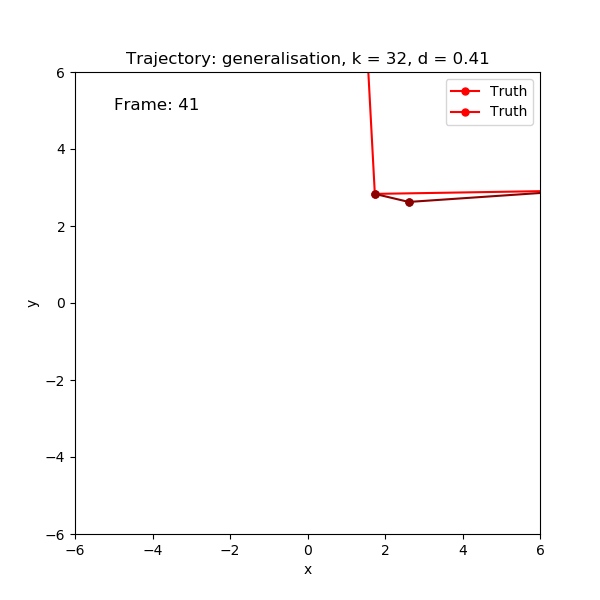

In [15]:
# Visualize trajectories
plt.close('all')
fig_animate3 = plt.figure(1, figsize=(6, 6))
ax3 = fig_animate3.add_subplot(1, 1, 1)

# Visualize trajectories for number_of_masses = 7
edges = []
contact_edges = []
time_text = ax3.text(-5, 5, "Frame: "+str(0),fontsize=12)
num_nodes = true_trajectory_ge_np.shape[1]

def init():
    for i in range(num_nodes-1):
        if(i==0):
            edges.append(ax3.plot([],[], linestyle='-', marker='o', markersize=5, color="red",label="Truth"))
        else:
            edges.append(ax3.plot([],[], linestyle='-', marker='o', markersize=5, color="red"))
    
    for i in range(len(contact_nodes_ge)):
        contact_edges.append(ax3.plot([],[], linestyle='-', marker='o', markersize=5, color="darkred"))              
    return edges, contact_edges,time_text
    
ax3.set_xlim(-6, 6)
ax3.set_ylim(-6, 6)


def animate(z):
    true_tr = true_trajectory_ge_np[z]                                
    time_text.set_text("Frame: "+str(z))        
    for i in range(num_nodes-2):
        left = i
        right = i+1
        
        if (right==num_nodes):
            break
                     
        edges[i][0].set_data([true_tr[left,0],true_tr[right,0]],[true_tr[left,1],true_tr[right,1]])
    edges[3][0].set_data([true_tr[0,0],true_tr[3,0]],[true_tr[0,1],true_tr[3,1]])    
    
    for node_n,i in zip(contact_nodes_te,range(len(contact_nodes_te))):
        contact_edges[i][0].set_data([true_tr[node_n,0],true_tr[4,0]],[true_tr[node_n,1],true_tr[4,1]])
    
    legend = ax3.legend()
    return legend, contact_edges, edges,time_text

ax3.set_title("Trajectory: generalisation, k = "+str(np.round(spring_const,2))+", d = "+str(np.round(damping_ratio,2)))
ax3.set_xlabel("x")
ax3.set_ylabel("y")

anim = animation.FuncAnimation(fig_animate3, animate,init_func = init, interval = step_size * 1000, frames=num_time_steps, blit=False, repeat=False)
#Save animation
if os.path.exists(os.path.join(path_animations,"GroundTruth","ground_truth_trajectory_ge_masses.gif")):
    print("The file: "+ "ground_truth_trajectory_ge_masses.gif" + "already exists. Delete it before saving a new animation!")
else:
    if not os.path.exists(os.path.join(path_animations,"GroundTruth")):
        os.makedirs(os.path.join(path_animations,"GroundTruth"))
                  
    anim.save(os.path.join(path_animations,"GroundTruth","ground_truth_trajectory_ge_masses.gif"), writer='imagemagick', fps=20)

                     

plt.show()

### Plot rollout for test system

Traceback (most recent call last):
  File "/home/bence/miniconda3/envs/tensorEnv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/bence/miniconda3/envs/tensorEnv/lib/python3.6/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


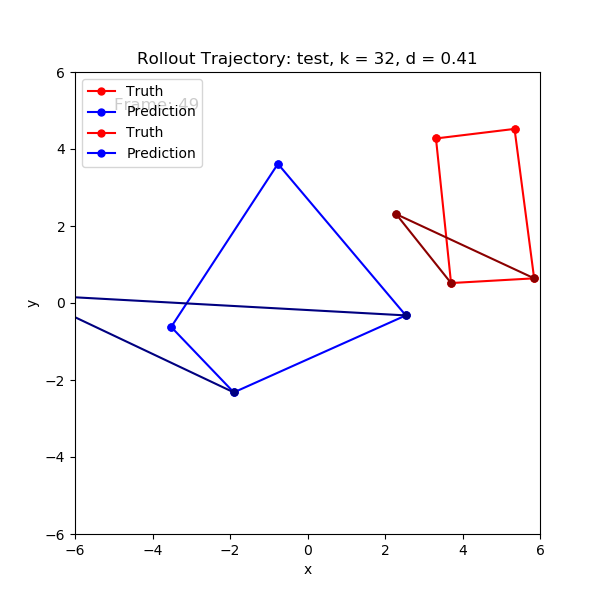

In [16]:
# Visualize trajectories
plt.close('all')
fig_animate3 = plt.figure(1, figsize=(6, 6))
ax3 = fig_animate3.add_subplot(1, 1, 1)

# Visualize trajectories for number_of_masses = 4

edges = []
edges1 = []
contact_edges = []
contact_edges1 = []

time_text = ax3.text(-5, 5, "Frame: "+str(0),fontsize=12)
num_nodes = true_trajectory_te_np.shape[1]
    
def init():
    for i in range(num_nodes-1):
        if(i==0):
            edges.append(ax3.plot([],[], linestyle='-', marker='o', markersize=5, color="red",label="Truth"))
            edges1.append(ax3.plot([],[], linestyle='-', marker='o', markersize=5, color="blue",label="Prediction"))
        else:
            edges.append(ax3.plot([],[], linestyle='-', marker='o', markersize=5, color="red"))
            edges1.append(ax3.plot([],[], linestyle='-', marker='o', markersize=5, color="blue"))
    
    for i in range(len(contact_nodes_te)):
        contact_edges.append(ax3.plot([],[], linestyle='-', marker='o', markersize=5, color="darkred"))   
        contact_edges1.append(ax3.plot([],[], linestyle='-', marker='o', markersize=5, color="navy"))
        
    return edges,edges1,contact_edges,contact_edges1,time_text
    
ax3.set_xlim(-6, 6)
ax3.set_ylim(-6, 6)


def animate(z):
    
    true_tr = true_trajectory_te_np[z]
    pred_tr = predicted_trajectory_te_np[z]                              
    time_text.set_text("Frame: "+str(z))
    for i in range(num_nodes-2):
        left = i
        right = i+1
        
        if (right==num_nodes):
            break
                     
        edges[i][0].set_data([true_tr[left,0],true_tr[right,0]],[true_tr[left,1],true_tr[right,1]])
        edges1[i][0].set_data([pred_tr[left,0],pred_tr[right,0]],[pred_tr[left,1],pred_tr[right,1]])
    edges[3][0].set_data([true_tr[0,0],true_tr[3,0]],[true_tr[0,1],true_tr[3,1]])   
    edges1[3][0].set_data([pred_tr[0,0],pred_tr[3,0]],[pred_tr[0,1],pred_tr[3,1]])
    
    for node_n,i in zip(contact_nodes_te,range(len(contact_nodes_te))):
        contact_edges[i][0].set_data([true_tr[node_n,0],true_tr[4,0]],[true_tr[node_n,1],true_tr[4,1]])
        contact_edges1[i][0].set_data([pred_tr[node_n,0],pred_tr[4,0]],[pred_tr[node_n,1],pred_tr[4,1]])
    
    legend = ax3.legend()
    return legend,edges,edges1,contact_edges,contact_edges1,time_text


ax3.set_title("Rollout Trajectory: test, k = "+str(np.round(spring_const,2))+", d = "+str(np.round(damping_ratio,2)))
ax3.set_xlabel("x")
ax3.set_ylabel("y")

anim = animation.FuncAnimation(fig_animate3, animate,init_func = init, interval = step_size * 1000, frames=num_time_steps, blit=False, repeat=False)
#Save animation
if os.path.exists(os.path.join(path_animations,"FullRollout","trajectory_te_masses.gif")):
    print("The file: "+ "trajectory_te_masses.gif" + "already exists. Delete it before saving a new animation!")
else:
    if not os.path.exists(os.path.join(path_animations,"FullRollout")):
        os.mkdir(os.path.join(path_animations,"FullRollout"))
                  
    anim.save(os.path.join(path_animations,"FullRollout","trajectory_te_masses.gif"), writer='imagemagick', fps=20)

               
plt.show()

### 7 masses 

Traceback (most recent call last):
  File "/home/bence/miniconda3/envs/tensorEnv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/bence/miniconda3/envs/tensorEnv/lib/python3.6/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


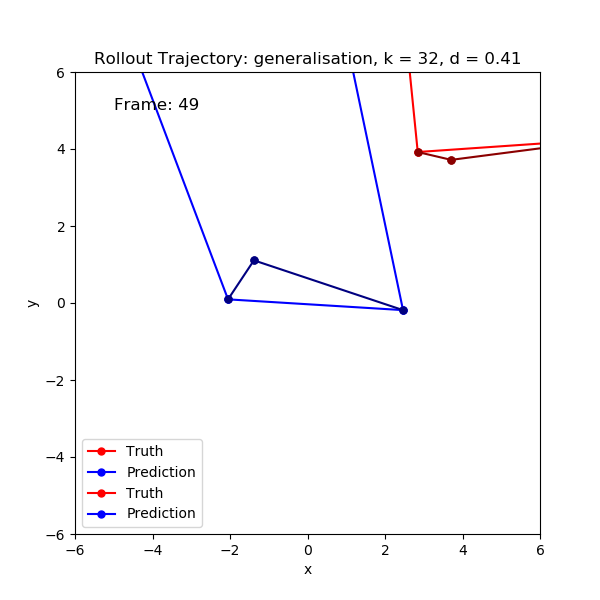

In [17]:
# Visualize trajectories
plt.close('all')
fig_animate3 = plt.figure(1, figsize=(6, 6))
ax3 = fig_animate3.add_subplot(1, 1, 1)

# Visualize trajectories for number_of_masses = 7
edges = []
edges1 = []
contact_edges = []
contact_edges1 = []

num_nodes = true_trajectory_ge_np.shape[1]
time_text = ax3.text(-5, 5, "Frame: "+str(0),fontsize=12)
    
def init():
    for i in range(num_nodes):
        if(i==0):
            edges.append(ax3.plot([],[], linestyle='-', marker='o', markersize=5, color="red",label="Truth"))
            edges1.append(ax3.plot([],[], linestyle='-', marker='o', markersize=5, color="blue",label="Prediction"))
        else:
            edges.append(ax3.plot([],[], linestyle='-', marker='o', markersize=5, color="red"))
            edges1.append(ax3.plot([],[], linestyle='-', marker='o', markersize=5, color="blue"))
            
    for i in range(len(contact_nodes_ge)):
        contact_edges.append(ax3.plot([],[], linestyle='-', marker='o', markersize=5, color="darkred"))   
        contact_edges1.append(ax3.plot([],[], linestyle='-', marker='o', markersize=5, color="navy")) 
    
    return edges,edges1,contact_edges,contact_edges1,time_text
    
ax3.set_xlim(-6, 6)
ax3.set_ylim(-6, 6)


def animate(z):
    true_tr = true_trajectory_ge_np[z]
    pred_tr = predicted_trajectory_ge_np[z]                              
    time_text.set_text("Frame: "+str(z))
    for i in range(num_nodes-2):
        left = i
        right = i+1
        
        if (right==num_nodes):
            break
                     
        edges[i][0].set_data([true_tr[left,0],true_tr[right,0]],[true_tr[left,1],true_tr[right,1]])
        edges1[i][0].set_data([pred_tr[left,0],pred_tr[right,0]],[pred_tr[left,1],pred_tr[right,1]])
        
    edges[3][0].set_data([true_tr[0,0],true_tr[3,0]],[true_tr[0,1],true_tr[3,1]])   
    edges1[3][0].set_data([pred_tr[0,0],pred_tr[3,0]],[pred_tr[0,1],pred_tr[3,1]])
    
    for node_n,i in zip(contact_nodes_te,range(len(contact_nodes_te))):
        contact_edges[i][0].set_data([true_tr[node_n,0],true_tr[4,0]],[true_tr[node_n,1],true_tr[4,1]])
        contact_edges1[i][0].set_data([pred_tr[node_n,0],pred_tr[4,0]],[pred_tr[node_n,1],pred_tr[4,1]])    
        
    
    legend = ax3.legend()
    return legend,edges,edges1,contact_edges,contact_edges1,time_text




ax3.set_title("Rollout Trajectory: generalisation, k = "+str(np.round(spring_const,2))+", d = "+str(np.round(damping_ratio,2)))
ax3.set_xlabel("x")
ax3.set_ylabel("y")

anim = animation.FuncAnimation(fig_animate3, animate,init_func = init, interval = step_size * 1000, frames=num_time_steps, blit=False, repeat=False)
#Save animation
if os.path.exists(os.path.join(path_animations,"FullRollout","trajectory_ge_masses.gif")):
    print("The file: "+ "trajectory_ge_masses.gif" + "already exists. Delete it before saving a new animation!")
else:
    if not os.path.exists(os.path.join(path_animations,"FullRollout")):
        os.mkdir(os.path.join(path_animations,"FullRollout"))
                  
    anim.save(os.path.join(path_animations,"FullRollout","trajectory_ge_masses.gif"), writer='imagemagick', fps=20)

    
plt.show()